# Clustering

### Load data

In [1]:
import numpy as np

with open("label_file.tsv","r") as f:
    lines1 = f.read().splitlines()[1:]
with open("vec_file.tsv","r") as f:
    lines2 = f.read().splitlines()

x, label, true_sent, pred_sent = [], [], [], []
act_set = set()
for line1,line2 in zip(lines1, lines2):
    a = line1.split("\t")
    b = line2.split("\t")
    x.append([float(bb) for bb in b])
    
    true_sent.append(a[0])
    pred_sent.append(a[1])
    label.append(a[2])
    
#     if a[2] == "Null":
#         pass
#     acts = a[2].split("&")
#     label.append(acts)
#     for act in acts:
#         act_set.add(act)     
    

x = np.array(x)  

# act_list = list(act_set)
# new_label = []
# for acts in label:
#     l = []
#     for act in acts:
#         l.append(act_list.index(act))
#     new_label.append(l)
# label = new_label
    

# x is 200-dim laten action
# label is the real dialogue act


### Reduce dimension

In [2]:
# Carefully for the parameters

# # PCA 
# from sklearn.decomposition import PCA
# print("Computing PCA projection")
# x_reduced = PCA(n_components=2).fit_transform(x)


# tSNE 
from sklearn.manifold import TSNE
print("Computing tSNE projection")
x_reduced = TSNE(n_components=2, perplexity=50, learning_rate=10, init='pca').fit_transform(x)


Computing tSNE projection


### Clustering 

In [3]:
# Kmeans
from sklearn.cluster import KMeans
k = 10
print("Clustering with Kmeans")

# clustering before dim deduction
kmeans= KMeans(n_clusters=k, random_state=0, max_iter=1000).fit(x)
y_pred = kmeans.predict(x)

# # clustering after dim deduction
# kmeans = KMeans(n_clusters=k, random_state=0).fit(x_reduced)
# y_pred = kmeans.predict(x_reduced)


Clustering with Kmeans


### Check dialog acts in each cluster

In [4]:
clusters = {}
points = {}
for i in range(k):
    clusters[i] = set()
    points[i] = []

for index, clas in enumerate(y_pred):
#     clusters[clas].add(label[index])
    clusters[clas].add(true_sent[index])
#     clusters[clas].add(pred_sent[index])
    points[clas].append(index)
    
for i in range(k):
    clusters[i] = list(clusters[i])

In [5]:
clusters[7]

['have a good day and if you need anything else please contact us .',
 'you are welcome enjoy your stay .',
 'okay , let me know if i can assist with anything else .',
 'you are welcome . enjoy your time in [value_place] !',
 'can i help you with anything else today ?',
 'you are very welcome . thank you for using [value_place] towninfo [value_area] .',
 'okay . thank you for calling !',
 'glad to help . have a wonderful day !',
 'no problem . have a great day !',
 'thank you for using our service . call us anytime . take care . goodbye .',
 'can i help you with anything else ?',
 '<unk> there anything else ?',
 'please call again if we can further assist you . goodbye .',
 'you as well ! goodbye !',
 'thank you , enjoy your visit .',
 'thank you for using the [value_place] towninfo [value_area] . have a great day .',
 'great . thank you for contacting [value_place] towninfo [value_area] .',
 'you are welcome . please contact us again if we can help in the future . have a great day .',

In [6]:
### cheat here

clusters[0] = [
 'i have [value_count] trains matching your request . the [value_count] trains leave on [value_day] at [value_time] , [value_time] , and [value_time] . was there [value_count] that you preferred ?',
 'there are multiple trains leaving that match your request . when is the earliest you would want to leave ?',
'[train_id] leaves [value_day] at [value_time] and arrives at [value_time] . will this [value_count] work for you ?',
'okay , what time would you like to arrive ? i have [value_count] trains on [value_day] .',
"i can help you with that , but first , i'll need more info . what are your departure and arrival location -s ?",
]

clusters[1] = [
  'booking was successful . the table will be reserved for [value_count] minutes . your reference number is [restaurant_reference] . can i help with anything else ?',  
 'i have successfully booked your table ! your reference number is <unk> . anything else i can help you with today ?',   
 'your booking for the [hotel_name] is successful . your reference number is [hotel_reference] . can i help you with anything else ?',
  '[hotel_reference] is your reference number for that booking . is there anything else i can do ?',  
'okay , your room is reserved . the reference number is [hotel_reference] . is there anything else i can help with ?', 
]

clusters[2] = [
  'i have booked you a taxi leaving at [value_time] . the car will be a [taxi_type] and contact number is [taxi_phone] . anything else today ?',  
   
]





### Visualize in Matplotlib

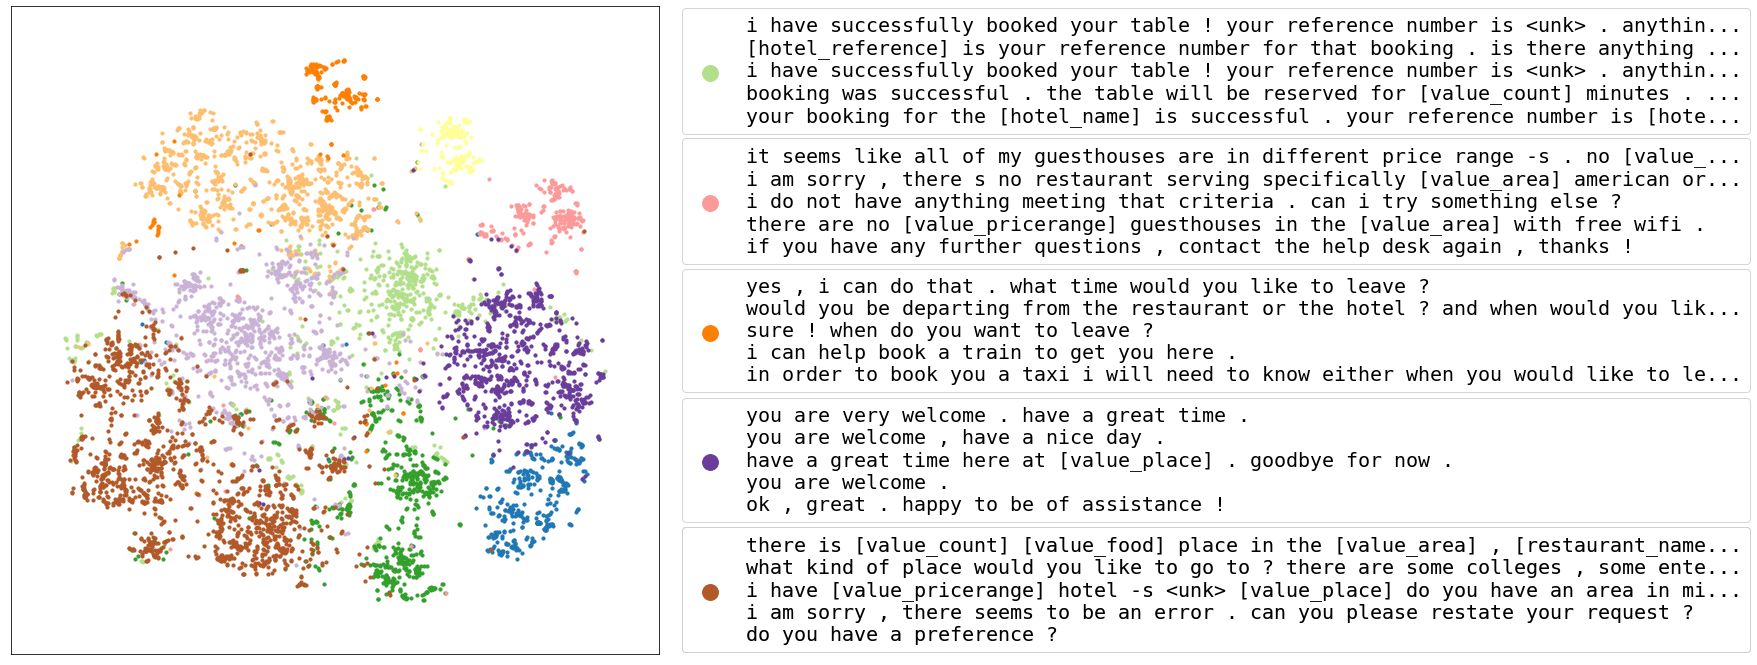

In [9]:
# Plot
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
# %matplotlib inline

x_min, x_max = np.min(x_reduced, 0), np.max(x_reduced, 0)
X = (x_reduced - x_min) / (x_max - x_min) # scale the values to fit    
 
fig, ax = plt.subplots(1, 1, figsize=(40, 10))
fig.subplots_adjust(left=0.05, bottom=0.05, top=0.95, right=0.95)

# ax.set_title(ax_name, fontsize=20)
ax.set_ylim((-0.1, 1.1))
ax.set_xlim((-0.1,1.1))

ax.set_xticks([])
ax.set_yticks([])

colors = get_cmap("Paired", k+1) # CMRmap # Set2 # Set1 # Paired

plots = []
for i in range(k):
    p = points[i]
    plot = ax.scatter(X[:, 0][p], X[:, 1][p], s=10, color=colors(i+1))
    plots.append(plot)

# Legend
num_show = 5
cluster_list = [1, 3, 5, 7, 9]
max_seq_len=80
# # Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.25, box.height])

legends = []
j = 0
for i in cluster_list:
    text = []
    for d in np.random.choice(clusters[i], 5):
        if len(d) > max_seq_len:
            sentence = d[:max_seq_len] + "..."
        else:
            sentence = d.ljust(max_seq_len+3, " ") 
        text.append(sentence)
    text = "\n".join(text)
    leg = ax.legend([plots[i]], [text], loc='center right', bbox_to_anchor=(2.7, 0.9-0.2*j), ncol=1,
              fontsize=20, markerscale=5, columnspacing=0.3, 
                    handletextpad=0.8, handlelength=2.0,
                   borderpad=0.4,borderaxespad=0.5,
                   prop={"family":"monospace","size":20}) # serif monospace
    
    legends.append(leg)
    j += 1
    
for i in range(num_show):
    plt.gca().add_artist(legends[i])

plt.savefig('../outputs/clustering.pdf', dpi=600)

plt.show()


            

In [238]:
https://blog.csdn.net/lly1122334/article/details/88535217

'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 
'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 
'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r',
'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r',
'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 
'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 
'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 
'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 
'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 
'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 
'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 
'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r',
'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 
'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 
'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 
'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r',
'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer',
'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r',
'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis',
'viridis_r', 'winter', 'winter_r'






('viridis_r', 'winter', 'winter_r')

### Visualize in TensorBoard

In [8]:
# Kmeans
from sklearn.cluster import KMeans
k = 20
kmeans = KMeans(n_clusters=k, random_state=0).fit(x)
y = kmeans.predict(x)

clusters = dict()
for i in range(k):
    clusters[i] = []
    
for index, clas in enumerate(y):
    clusters[clas].append(label[index])

wf = open("cluster_label.tsv","w")
wf.write("class\ttrue_str\tpred_str\tdialog_act\n")
for index, clas in enumerate(y):
    line = lines1[index]
    new_line = "%s\t%s\n"%(str(clas), line)
    wf.write(new_line)

In [9]:
# Mixture of Gauss
from sklearn.mixture import GaussianMixture
k = 32
gmm = GaussianMixture(n_components=k, covariance_type='full').fit(x)
y = gmm.predict(x)

# Plot Training Curvers

In [61]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os

exp_name = '2.0'
# exp_name = '2.1'

BASE_DIR = './'


# Success/Match
ss, se = 0, 100
x_all, success_all, match_all, bleu_all = [], [], [], []

# hrl
metric = ["success", "match", "bleu"]
for m in metric:
    file_path = os.path.join(BASE_DIR, "hrl_%s"%exp_name,"val_%s.csv"%m)
    with open(file_path, "r") as f:
        curve = pd.read_csv(f)
        value = curve.values
        value = value[ss:se]
        x, y = value[ss:, 1], value[ss:, 2]
        x, y = np.array(x), np.array(y)*100

        if m == "success":
            x_all.append(x)
            success_all.append(y)
        elif m == "match":
            match_all.append(y)
        elif m == "bleu":
            bleu_all.append(y)      
se = len(x_all[-1]) + ss

# larl + word
models_name = ['larl', 'word']

for model_name in models_name:
    file_path = os.path.join(BASE_DIR, "%s_%s"%(model_name,exp_name), "val-rl.tsv")
    with open(file_path, "r") as f:
        lines = f.read().splitlines()
        end = min(se, len(lines))
        lines = lines[ss:end] # tricks
        s, m, x = [], [], []
        for line in lines:
            record = line.split("\t")
            x.append(int(record[0]))
            m.append(float(record[3])*100)
            s.append(float(record[2])*100)
    file_path = os.path.join(BASE_DIR, "%s_%s"%(model_name,exp_name), "val-ppl.tsv")
    with open(file_path, "r") as f:
        lines = f.read().splitlines()
        end = min(se, len(lines))
        lines = lines[ss:end] # tricks
        b = []
        for line in lines:
            record = line.split("\t")
            b.append(float(record[2])*100)           
    x_all.append(np.array(x))
    success_all.append(np.array(s)) # success
    match_all.append(np.array(m))
    bleu_all.append(np.array(b))
 
# human
x_all.append(x_all[-1])
steps = len(x_all[-1])
if exp_name == "2.0":
    success_all.append(np.array([82.7]*steps))
    match_all.append(np.array([91]*steps))
    bleu_all.append(np.array([100]*steps))

else:
    success_all.append(np.array([79.1]*steps))
    match_all.append(np.array([86.3]*steps))
    bleu_all.append(np.array([100]*steps))    

xname = 'Training Episode'
labels = ['HSTDS',
          'LaRL',
          'WE2E',
          'Human'
         ]

# labels.pop(0)

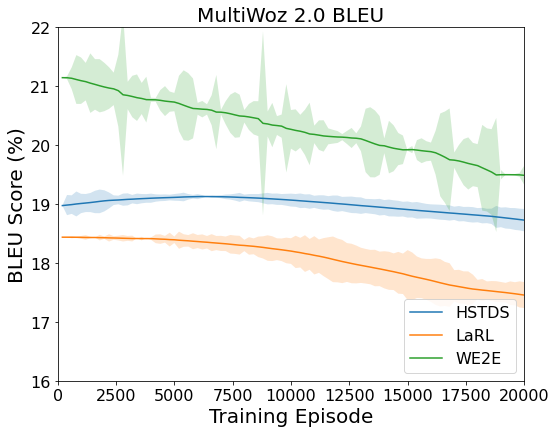

In [64]:
# plot Success
file_name = "multiwoz_%s-success"%exp_name
ax_name = "MultiWoz %s Success"%exp_name
yname = 'Success Rate (%)'
y_min, y_max = 55,90
x_min, x_max = 0, x_all[0][-1]
weight = 0.95
variance = 0.25
alpha = 0.2
y_all = success_all

# plot Match
file_name = "multiwoz_%s-inform"%exp_name
ax_name = "MultiWoz %s Inform"%exp_name
yname = 'Inform Rate (%)'
y_min, y_max = 65, 100
x_min, x_max = 0, x_all[0][-1]
weight = 0.95
variance = 0.25
alpha = 0.2
y_all = match_all


# plot BLEU
file_name = "multiwoz_%s-bleu"%exp_name
ax_name = "MultiWoz %s BLEU"%exp_name
yname = 'BLEU Score (%)'
y_min, y_max = 16, 22
x_min, x_max = 0, x_all[0][-1]
weight = 0.99
variance = 0.2
alpha = 0.2
y_all = bleu_all

# # plot Combined
# ax_name = "MultiWoz %s Combined Score"%exp_name
# yname = 'Combined Score'
# y_min, y_max = 85, 110
# x_min, x_max = 0, x_all[0][-1]
# weight = 0.9
# variance = 0.25
# alpha = 0.2

# smooth function for plots
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
fig.subplots_adjust(left=0.14, bottom=0.132, top=0.95, right=0.95)

ax1.set_title(ax_name, fontsize=20)
ax1.set_xlabel(xname, fontsize=20)
ax1.set_ylabel(yname, fontsize=20)
ax1.set_ylim((y_min, y_max))
ax1.set_xlim((x_min, x_max))
ax1.tick_params(labelsize=16)


for x, y, label in zip(x_all, y_all, labels):  
    ys = smooth(y, weight)
    if label == "Human":
#         ax1.plot(x, ys, label=label, linewidth=1.5, linestyle="--")
        pass
    else:
        ax1.plot(x, ys, label=label, linewidth=1.5)
    e = (ys - y)*variance
    ax1.fill_between(x, ys-e, ys+e, alpha=alpha)


# for x, s, m, b, label in zip(x_all, success_all, match_all, bleu_all, labels):  
#     y = ( s + m )* 0.5 + b
#     ys = smooth(y, weight)
#     if label == "Human":
#         ax1.plot(x, ys, label=label, linewidth=1.5, linestyle="--")
#     else:
#         ax1.plot(x, ys, label=label, linewidth=1.5)
#     e = (ys - y)*variance
#     ax1.fill_between(x, ys-e, ys+e, alpha=alpha)


ax1.legend(fontsize=16, loc='lower right')

plt.savefig(BASE_DIR + 'outputs/%s.pdf'%file_name, dpi=600)
            
            

In [65]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os

# exp_name = '2.0'
exp_name = '2.1'

BASE_DIR = './'


# Success/Match
ss, se = 0, 100
x_all, success_all, match_all, bleu_all = [], [], [], []

# hrl
metric = ["success", "match", "bleu"]
for m in metric:
    file_path = os.path.join(BASE_DIR, "hrl_%s"%exp_name,"val_%s.csv"%m)
    with open(file_path, "r") as f:
        curve = pd.read_csv(f)
        value = curve.values
        value = value[ss:se]
        x, y = value[ss:, 1], value[ss:, 2]
        x, y = np.array(x), np.array(y)*100

        if m == "success":
            x_all.append(x)
            success_all.append(y)
        elif m == "match":
            match_all.append(y)
        elif m == "bleu":
            bleu_all.append(y)      
se = len(x_all[-1]) + ss

# larl + word
models_name = ['larl', 'word']

for model_name in models_name:
    file_path = os.path.join(BASE_DIR, "%s_%s"%(model_name,exp_name), "val-rl.tsv")
    with open(file_path, "r") as f:
        lines = f.read().splitlines()
        end = min(se, len(lines))
        lines = lines[ss:end] # tricks
        s, m, x = [], [], []
        for line in lines:
            record = line.split("\t")
            x.append(int(record[0]))
            m.append(float(record[3])*100)
            s.append(float(record[2])*100)
    file_path = os.path.join(BASE_DIR, "%s_%s"%(model_name,exp_name), "val-ppl.tsv")
    with open(file_path, "r") as f:
        lines = f.read().splitlines()
        end = min(se, len(lines))
        lines = lines[ss:end] # tricks
        b = []
        for line in lines:
            record = line.split("\t")
            b.append(float(record[2])*100)           
    x_all.append(np.array(x))
    success_all.append(np.array(s)) # success
    match_all.append(np.array(m))
    bleu_all.append(np.array(b))
 
# human
x_all.append(x_all[-1])
steps = len(x_all[-1])
if exp_name == "2.0":
    success_all.append(np.array([82.7]*steps))
    match_all.append(np.array([91]*steps))
    bleu_all.append(np.array([100]*steps))

else:
    success_all.append(np.array([79.1]*steps))
    match_all.append(np.array([86.3]*steps))
    bleu_all.append(np.array([100]*steps))    

xname = 'Training Episode'
labels = ['HRL',
          'LaRL',
          'Word-Level',
          'Human'
         ]

# labels.pop(0)

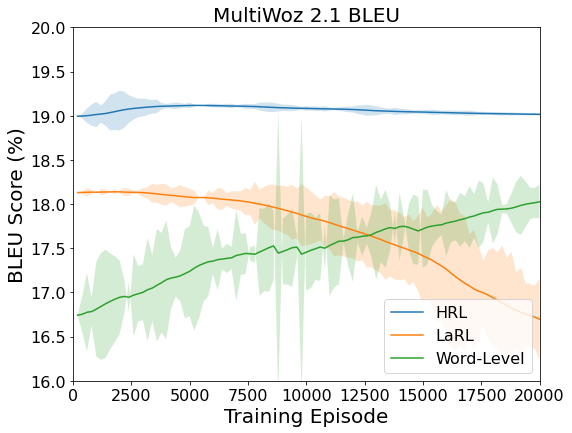

In [69]:
# plot Success
file_name = "multiwoz_%s-success"%exp_name
ax_name = "MultiWoz %s Success"%exp_name
yname = 'Success Rate (%)'
y_min, y_max = 55,85
x_min, x_max = 0, x_all[0][-1]
weight = 0.95
variance = 0.25
alpha = 0.2
y_all = success_all

# plot Match
file_name = "multiwoz_%s-inform"%exp_name
ax_name = "MultiWoz %s Inform"%exp_name
yname = 'Inform Rate (%)'
y_min, y_max = 65, 95
x_min, x_max = 0, x_all[0][-1]
weight = 0.95
variance = 0.25
alpha = 0.2
y_all = match_all


# plot BLEU
file_name = "multiwoz_%s-bleu"%exp_name
ax_name = "MultiWoz %s BLEU"%exp_name
yname = 'BLEU Score (%)'
y_min, y_max = 16, 20
x_min, x_max = 0, x_all[0][-1]
weight = 0.99
variance = 0.2
alpha = 0.2
y_all = bleu_all

# # plot Combined
# ax_name = "MultiWoz %s Combined Score"%exp_name
# yname = 'Combined Score'
# y_min, y_max = 85, 110
# x_min, x_max = 0, x_all[0][-1]
# weight = 0.9
# variance = 0.25
# alpha = 0.2

# smooth function for plots
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
fig.subplots_adjust(left=0.14, bottom=0.132, top=0.95, right=0.95)

ax1.set_title(ax_name, fontsize=20)
ax1.set_xlabel(xname, fontsize=20)
ax1.set_ylabel(yname, fontsize=20)
ax1.set_ylim((y_min, y_max))
ax1.set_xlim((x_min, x_max))
ax1.tick_params(labelsize=16)


for x, y, label in zip(x_all, y_all, labels):  
    ys = smooth(y, weight)
    if label == "Human":
#         ax1.plot(x, ys, label=label, linewidth=1.5, linestyle="--")
        pass
    else:
        ax1.plot(x, ys, label=label, linewidth=1.5)
    e = (ys - y)*variance
    ax1.fill_between(x, ys-e, ys+e, alpha=alpha)


# for x, s, m, b, label in zip(x_all, success_all, match_all, bleu_all, labels):  
#     y = ( s + m )* 0.5 + b
#     ys = smooth(y, weight)
#     if label == "Human":
#         ax1.plot(x, ys, label=label, linewidth=1.5, linestyle="--")
#     else:
#         ax1.plot(x, ys, label=label, linewidth=1.5)
#     e = (ys - y)*variance
#     ax1.fill_between(x, ys-e, ys+e, alpha=alpha)


ax1.legend(fontsize=16, loc='lower right')

plt.savefig(BASE_DIR + 'outputs/%s.pdf'%file_name, dpi=600)
            
            

# Plot dynamics

In [162]:
def normalize(values, index=0):
    # taks reciprocal
    if index==0:
        assert 0 not in values, '0 in values'
        return 1./ values
    # [0,1] all
    elif index==1:
        return (values-np.min(values))/(np.max(values)-np.min(values))
    elif index==2:
        norm_v = []
        for v in values:
            a = (v-np.min(v)) / (np.max(v)-np.min(v))
            norm_v.append(v)
        return np.stack(norm_v)
    else:
        return values

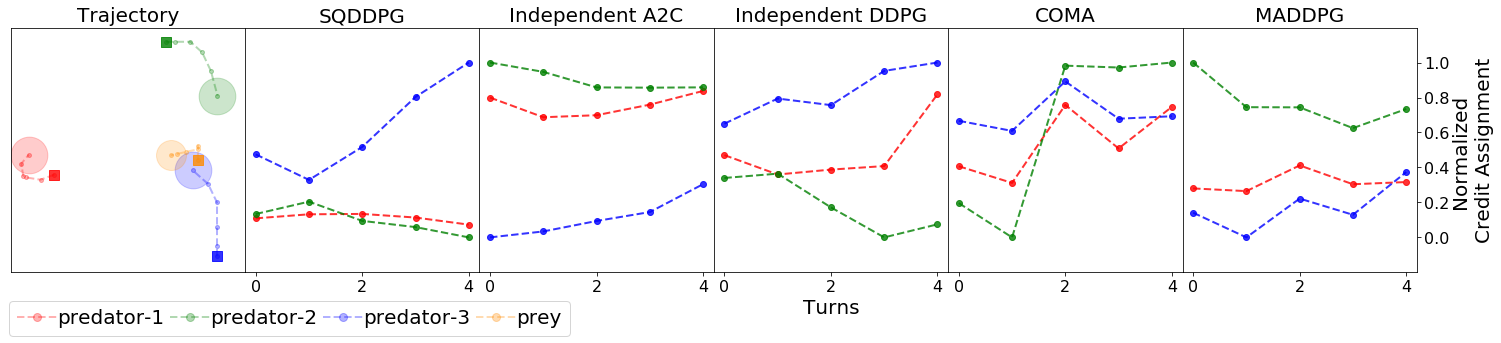

In [166]:
ep = 0

BASE_DIR = './tools/MARL/shapley-q-value-data/simple_tag/dynamics/'
DATA_DIR = BASE_DIR + 'data/episode_%s/'%str(ep)

# load data
pos = np.load(DATA_DIR+'position.npy')
sqddpg = np.load(DATA_DIR+'sqddpg_value.npy')
maddpg = np.load(DATA_DIR+'maddpg_value.npy')
coma = np.load(DATA_DIR+'coma_value.npy')
iddpg = np.load(DATA_DIR+'iddpg_value.npy')
iac = np.load(DATA_DIR+'iac_value.npy')
values = [sqddpg, iac, iddpg, coma, maddpg]

dynamics_label = ['SQDDPG', 'Independent A2C','Independent DDPG', 'COMA', 'MADDPG', ]
colors = ['r', 'g', 'b', 'darkorange']
sizes = [3,3,3,2]
sizes = [i*450 for i in sizes]
label = ['predator-1','predator-2','predator-3','prey']


# create figure
fig,axes=plt.subplots(1,6, figsize=(21,5))
fig.subplots_adjust(left=0.01, bottom=0.2, top=0.88, right=0.94,hspace=0, wspace=0)

# plot dynamics
for i in range(pos.shape[1]):
    X = pos[:,i,0]
    Y = pos[:,i,1]
    axes[0].plot(X, Y, colors[i], linestyle='dashed', linewidth=2, markersize=4, marker='o',alpha=0.3, label=label[i])
    axes[0].scatter(X[0], Y[0], s=100, c=colors[i], alpha=0.8, marker='s')
    axes[0].scatter(X[-1], Y[-1], s=sizes[i], c=colors[i], alpha=0.2, marker='o')
    axes[0].set_title('Trajectory',fontsize=20)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
axes[0].legend(loc='lower left', bbox_to_anchor=(-0.05,-0.3), ncol=4, 
               fontsize=20,markerscale=2, columnspacing=0.3, handletextpad=0.0, handlelength=2.0)

# plot values of model i
for i, value in enumerate(values):
    ax = axes[i+1]
    X = np.arange(0, value.shape[0], 1)
    value = normalize(value,1)
    for j in range(3):
        Y = value[:,j]
        ax.plot(X, Y, colors[j], linestyle='dashed', linewidth=2, markersize=6, marker='o',alpha=0.8)
    ax.set_title(dynamics_label[i], fontsize=20)
    ax.set_yticks([])
    ax.set_ylim((-0.2, 1.2))
    ax.tick_params(labelsize=16)
    if i==2:
        ax.set_xlabel('Turns', fontsize=20)

# adjust figure
axes[-1].set_yticks(np.arange(-0.0,1.2,0.2))
axes[-1].tick_params(labelsize=16)
axes[-1].set_ylabel('Normalized \nCredit Assignment', fontsize=20)
axes[-1].yaxis.set_label_position("right")
axes[-1].yaxis.tick_right()


plt.savefig(BASE_DIR+ "dynamics_%s.pdf"%ep, dpi=600)


# Calculate correlations

In [172]:
eps = 1000
BASE_DIR = './tools/MARL/shapley-q-value-data/simple_tag/dynamics/'

d_all = []
v_all = {'sqddpg':[], 'maddpg':[], 'coma':[], 'iddpg':[], 'iac':[]}

# seed = 754
# np.random.seed(seed)

for i in range(eps):
    
    ep = np.random.randint(0,1000)

    DATA_DIR = BASE_DIR + 'data/episode_%s/'%str(ep)
    
    # load values
    sqddpg = np.load(DATA_DIR+'sqddpg_value.npy') # (n, 3)
    maddpg = np.load(DATA_DIR+'maddpg_value.npy') # (n, 3)
    coma = np.load(DATA_DIR+'coma_value.npy') # (n, 3)
    iddpg = np.load(DATA_DIR+'iddpg_value.npy') # (n, 3)
    iac = np.load(DATA_DIR+'iac_value.npy') # (n, 3)
    values = [sqddpg, maddpg, coma, iddpg, iac]

    # normalize values
    i=0
    for key in v_all.keys():
        value = normalize(values[i][-1:,:],4)
        v_all[key].append(value) # (1,3)
        i+=1
    
    # load positions
    pos = np.load(DATA_DIR+'position.npy') # (n+1, 4, 2)
    distance = np.zeros((pos.shape[0],3),dtype=np.float32)
    for i in range(3):
        X = pos[:,i,0]-pos[:,-1,0]
        Y = pos[:,i,1]-pos[:,-1,1]
        d = np.sqrt(X**2 + Y**2)
        distance[:,i] = d
    d = normalize(distance[-1,:],0)
    d_all.append(d) # (1,3)
#         d_all.append(dd[-2:-1,:])

# calculate correlations
from scipy.stats import pearsonr, spearmanr
d_all = np.stack(d_all)

for key in v_all.keys():
    d = d_all.reshape(-1)
    v = np.stack(v_all[key]).reshape(-1)
    print(key, pearsonr(v,d))


sqddpg (0.28302189997105637, 2.2710197667639726e-56)
maddpg (0.04314436894462636, 0.018116423767820165)
coma (0.1331180714023496, 2.4660674544401857e-13)
iddpg (0.05316531661686495, 0.0035816857679176937)
iac (0.08117821650113163, 8.51496327645016e-06)


# Run Tester

In [263]:
# Tester

import numpy as np
import torch
from utilities.util import *
import time
import signal
import sys



class Tester(object):

    def __init__(self, env, args, sqddpg, maddpg, coma, iddpg, iac):
        self.env = env
        self.sqddpg = sqddpg.eval()
        self.coma = coma.eval()
        self.maddpg = maddpg.eval()
        self.iddpg = iddpg.eval()
        self.iac = iac.eval()
        self.args = args
        self.cuda_ = self.args.cuda
    
    def run_game(self, episodes):
        
        action = cuda_wrapper(torch.zeros((1, self.args.agent_num, self.args.action_dim)), cuda=self.cuda_)
        info = {}

        last_hidden = None
        schedule = None
        self.all_reward = []
        self.all_turn = []
        self.all_success = [] # special for traffic junction

        for ep in range(episodes):
            position = []
            sqddpg_values = []
            maddpg_values = []
            coma_values = []
            iddpg_values = []
            iac_values = []
            print ('The episode {} starts!'.format(ep))
            episode_reward = []
            state = self.env.reset()
            t = 0
            while True:
                pos = []
                for agent in self.env.world.agents:
                    pos.append(agent.state.p_pos)
                pos = np.stack(pos)
                position.append(pos)
                
                state_  = cuda_wrapper(prep_obs(state).contiguous().view(1, self.args.agent_num, self.args.obs_size), cuda=self.cuda_)
#                 state_ = state_.cpu() # TODO
                action_out = self.sqddpg.policy(state_)
                action = select_action(self.args, action_out, status='test')
                _, actual = translate_action(self.args, action, self.env)
                next_state, reward, done, debug = self.env.step(actual)
                action_ = action
#                 action_ = action.cpu() # TODO
            

                sqddpg_value = np.sum(self.sqddpg.marginal_contribution(state_, action_).detach().cpu().numpy(), axis=-1)[0,0]
                maddpg_value = np.sum(self.maddpg.value(state_, action_).detach().cpu().numpy(), axis=-1)[0]
                coma_value = np.sum(self.coma.value(state_, action_).detach().cpu().numpy() * action_.cpu().numpy(), axis=-1)[0]
                iddpg_value = np.sum(self.iddpg.value(state_, action_).detach().cpu().numpy(), axis=-1)[0]
                iac_value = np.sum(self.iac.value(state_, action_).detach().cpu().numpy() * action_.cpu().numpy(), axis=-1)[0]
                
                sqddpg_values.append(sqddpg_value)
                maddpg_values.append(maddpg_value)
                coma_values.append(coma_value)     
                iddpg_values.append(iddpg_value)
                iac_values.append(iac_value)
                
#                 print(iddpg_value, iac_value)
                
                value = []
                episode_reward.append(np.mean(reward))

                if np.all(done) or t==self.args.max_steps-1:
                    print ('The episode {} is finished!'.format(ep))
                    self.all_reward.append(np.mean(episode_reward))
                    self.all_turn.append(t+1)
                    pos = []
                    for agent in self.env.world.agents:
                        pos.append(agent.state.p_pos)
                    pos = np.stack(pos)
                    position.append(pos)
                    break
                t += 1
                state = next_state
                
            self.positions = np.stack(position)
            self.sqddpg_values = np.stack(sqddpg_values)
            self.maddpg_values = np.stack(maddpg_values)
            self.coma_values = np.stack(coma_values)
            self.iddpg_values = np.stack(iddpg_values)
            self.iac_values = np.stack(iac_values)
#             self.save(ep)
                
    def print_info(self):
        episodes = len(self.all_reward)
        print("\n"+"="*10+ " REUSLTS "+ "="*10)
        print ('Episode: {:4d}'.format(episodes))
        print('Mean Reward: {:2.4f}/{:2.4f}'.format(np.mean(self.all_reward),np.std(self.all_reward)))
        print('Mean Turn: {:2.4f}/{:2.4f}'.format(np.mean(self.all_turn),np.std(self.all_turn)))


    def save(self,ep):
        base_dir = save_path + 'dynamics/episode_%s/'%ep
        os.mkdir(base_dir)
        np.save(base_dir + "position", self.positions)
        np.save(base_dir + "sqddpg_value", self.sqddpg_values)
        np.save(base_dir + "maddpg_value", self.maddpg_values)
        np.save(base_dir + "coma_value", self.coma_values)
        np.save(base_dir + "iddpg_value", self.iddpg_values)
        np.save(base_dir + "iac_value", self.iac_values)

In [ ]:
# load models

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
os.environ['CUDA_DEVICE_ORDER']="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']="1"
sys.path.append('./tools/MARL/multi-agent-rl')

save_path = 'tools/MARL/shapley-q-value-data/simple_tag/model_save/'
from utilities.tester import *


from args.simple_tag_independent_ddpg import *
model = Model[model_name]
PATH = save_path + 'simple_tag_independent_ddpg/model.pt'
target= model(args)
iddpg = model(args,target)
checkpoint = torch.load(PATH, map_location='cpu') if not args.cuda else torch.load(PATH)
iddpg.load_state_dict(checkpoint['model_state_dict'])
iddpg = iddpg.cuda()
# print(iddpg)

from args.simple_tag_independent_ac import *
model = Model[model_name]
PATH = save_path + 'simple_tag_independent_ac/model.pt'
target= model(args)
iac = model(args,target)
checkpoint = torch.load(PATH, map_location='cpu') if not args.cuda else torch.load(PATH)
iac.load_state_dict(checkpoint['model_state_dict'])
iac = iac.cuda()
# print(iac)


from args.simple_tag_maddpg import *
model = Model[model_name]
PATH = save_path + 'simple_tag_maddpg/model.pt'
target= model(args)
maddpg = model(args,target)
checkpoint = torch.load(PATH, map_location='cpu') if not args.cuda else torch.load(PATH)
maddpg.load_state_dict(checkpoint['model_state_dict'])
maddpg = maddpg.cuda()
# print(maddpg)

from args.simple_tag_coma_fc import *
model = Model[model_name]
PATH = save_path + 'simple_tag_coma/model.pt'
target = model(args)
coma = model(args,target)
checkpoint = torch.load(PATH, map_location='cpu')  if not args.cuda else torch.load(PATH)
coma.load_state_dict(checkpoint['model_state_dict'])
coma = coma.cuda()
# print(coma)


from args.simple_tag_sqddpg_old import *
model = Model[model_name]
PATH = save_path + 'simple_tag_sqddpg/model.pt'
target = model(args)
sqddpg = model(args,target)
checkpoint = torch.load(PATH, map_location='cpu') if not args.cuda else torch.load(PATH)
sqddpg.load_state_dict(checkpoint['model_state_dict'])
sqddpg = sqddpg.cuda()
# print(sqddpg)


In [ ]:
# run 1000 episodes

episodes = 1000

test = Tester(env(), args, sqddpg, maddpg, coma, iddpg, iac)
test.run_game(episodes=episodes)
test.print_info()

# eps = [0, 6, 11, 17, 19, 26, 32, 38, 43, 45, 59, 70, 78, 80, 81, 97, 98, 104, 115, 123, 126, 131, 135, 136,148]

In [6]:
import torch

a = torch.randn((3,10))
a


tensor([[ 0.9704,  0.7461, -0.1436, -0.9657,  0.6581,  1.7610, -0.6204,  0.5340,
         -0.8734, -0.8645],
        [-0.8816,  0.0494, -0.7635, -1.3153,  0.2908,  0.1693,  0.1671,  1.0775,
          0.8338,  0.3143],
        [ 0.4008,  0.3996,  0.5557, -0.1162,  0.6928, -0.0914,  1.6761,  0.1839,
         -1.1959, -2.2296]])

In [11]:
b = torch.cat([a]*2, dim=-1).view(-1, 10)
b

tensor([[ 0.9704,  0.7461, -0.1436, -0.9657,  0.6581,  1.7610, -0.6204,  0.5340,
         -0.8734, -0.8645],
        [ 0.9704,  0.7461, -0.1436, -0.9657,  0.6581,  1.7610, -0.6204,  0.5340,
         -0.8734, -0.8645],
        [-0.8816,  0.0494, -0.7635, -1.3153,  0.2908,  0.1693,  0.1671,  1.0775,
          0.8338,  0.3143],
        [-0.8816,  0.0494, -0.7635, -1.3153,  0.2908,  0.1693,  0.1671,  1.0775,
          0.8338,  0.3143],
        [ 0.4008,  0.3996,  0.5557, -0.1162,  0.6928, -0.0914,  1.6761,  0.1839,
         -1.1959, -2.2296],
        [ 0.4008,  0.3996,  0.5557, -0.1162,  0.6928, -0.0914,  1.6761,  0.1839,
         -1.1959, -2.2296]])